In [1]:
from SMILESTokenizer import SMILESTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df_train = pd.read_csv('dataset/HIV_train.csv')
my_tokenizer = SMILESTokenizer()
my_tokenizer.load_vocab('vocabulary/first_vocab')
def get_tokens_safe(smiles):
    canon = my_tokenizer.canonicalize(smiles)
    if canon:
        return my_tokenizer.tokenize(canon)
    return []


df_train['tokens'] = df_train['smiles'].apply(get_tokens_safe)

Successfully loaded vocabularies from vocabulary/first_vocab.


[15:32:25] Explicit valence for atom # 16 Al, 9, is greater than permitted
[15:32:33] Explicit valence for atom # 12 Al, 7, is greater than permitted
[15:32:33] Explicit valence for atom # 13 Al, 7, is greater than permitted
[15:32:35] WARNING: not removing hydrogen atom without neighbors
[15:32:35] WARNING: not removing hydrogen atom without neighbors
[15:32:35] Explicit valence for atom # 6 Ge, 5, is greater than permitted


In [42]:
def plot_token_lengths(df, tokenizer):

    df['token_len'] = df['tokens'].apply(len)

    plt.figure(figsize=(10, 6))

    sns.histplot(data=df, x='token_len', kde=True,bins=50)

    plt.title('Distribution of Token Sequence Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')

    len_mean = df['token_len'].mean()
    len_median = df['token_len'].median()
    len_95th = df['token_len'].quantile(0.95)

    plt.axvline(len_mean, color='red', linestyle='--', label=f'Mean: {len_mean:.1f}')
    plt.axvline(len_median, color='green', linestyle='-', label=f'Median: {len_median:.1f}')
    plt.axvline(len_95th, color='orange', linestyle=':', label=f'95th quantile: {len_95th:.1f}')


    plt.axvline(100, color='blue', linestyle='--', label='Proposed MAX_LEN (100)')
    plt.legend()
    plt.show()

    print(f"Max Token Length: {df['token_len'].max()}")
    print(f"95th Percentile: {df['token_len'].quantile(0.95)}")

In [43]:
def analyze_token_enrichment(df, tokenizer, top_n=25):

    # 2. Split by Class
    active_tokens = [t for sublist in df[df['HIV_active'] == 1]['tokens'] for t in sublist]
    inactive_tokens = [t for sublist in df[df['HIV_active'] == 0]['tokens'] for t in sublist]

    # 3. Calculate Probabilities (Densities)
    act_counts = Counter(active_tokens)
    inact_counts = Counter(inactive_tokens)

    total_act = len(active_tokens)
    total_inact = len(inactive_tokens)

    # Get all unique tokens from both sets
    all_tokens = set(act_counts.keys()) | set(inact_counts.keys())

    stats = []
    for t in all_tokens:
        # P(token | Active)
        p_active = act_counts.get(t, 0) / total_act
        # P(token | Inactive)
        p_inactive = inact_counts.get(t, 0) / total_inact

        # Metric: Difference in Probability
        # Multiplied by 100 for percentage points
        diff = (p_active - p_inactive) * 100

        # Filter out extremely rare tokens
        if (act_counts.get(t, 0) + inact_counts.get(t, 0)) > 50:
            stats.append({'Token': t, 'Difference': diff, 'P_Active': p_active})

    stats_df = pd.DataFrame(stats)

    # Sort by absolute difference to find the most "important" tokens
    stats_df['abs_diff'] = stats_df['Difference'].abs()
    top_df = stats_df.sort_values('abs_diff', ascending=False).head(top_n)

    # 4. Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Difference', y='Token', data=top_df)

    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.title(f'Top {top_n} Tokens Distinguishing Active vs Inactive Molecules', fontsize=14)
    plt.xlabel(
        'Enrichment in Active Molecules (Percentage Points) \n <--- Inactive Preferring | Active Preferring --->')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

In [44]:
def find_unique_active_tokens(df, tokenizer):

    active_tokens = set([t for sublist in df[df['HIV_active'] == 1]['tokens'] for t in sublist])
    inactive_tokens = set([t for sublist in df[df['HIV_active'] == 0]['tokens'] for t in sublist])

    # Tokens present in Active but NEVER in Inactive
    exclusive_active = active_tokens - inactive_tokens

    print(f"Tokens found ONLY in Active molecules: {exclusive_active}")

    # Tokens present in Inactive but NEVER in Active
    exclusive_inactive = inactive_tokens - active_tokens
    print(f"Tokens found ONLY in Inactive molecules: {exclusive_inactive}")

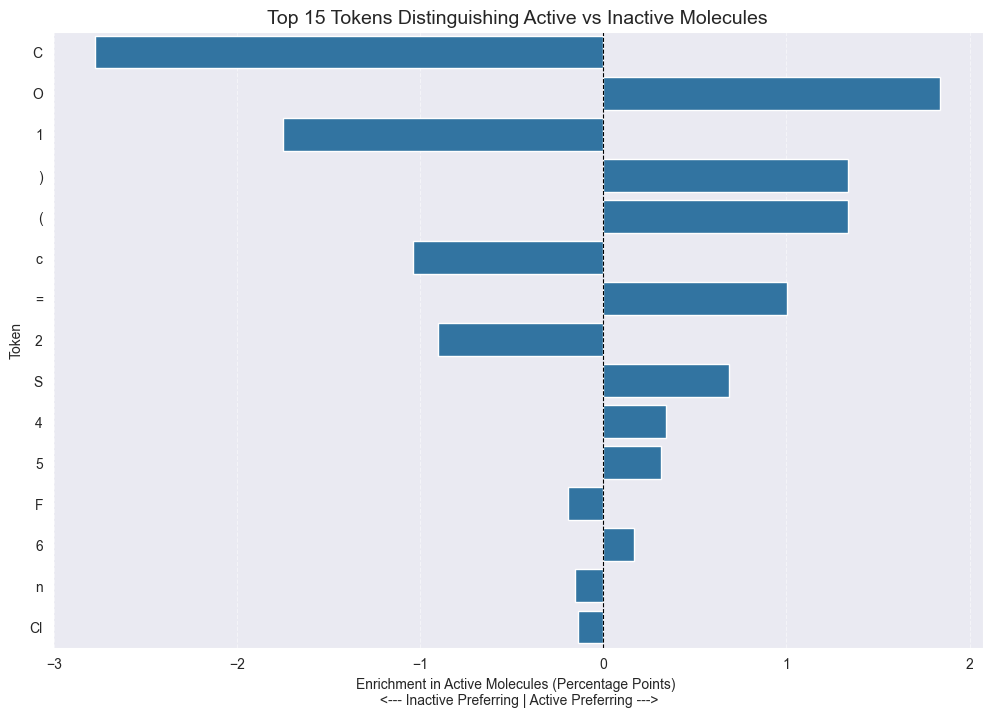

In [45]:
analyze_token_enrichment(df_train, my_tokenizer, 15)

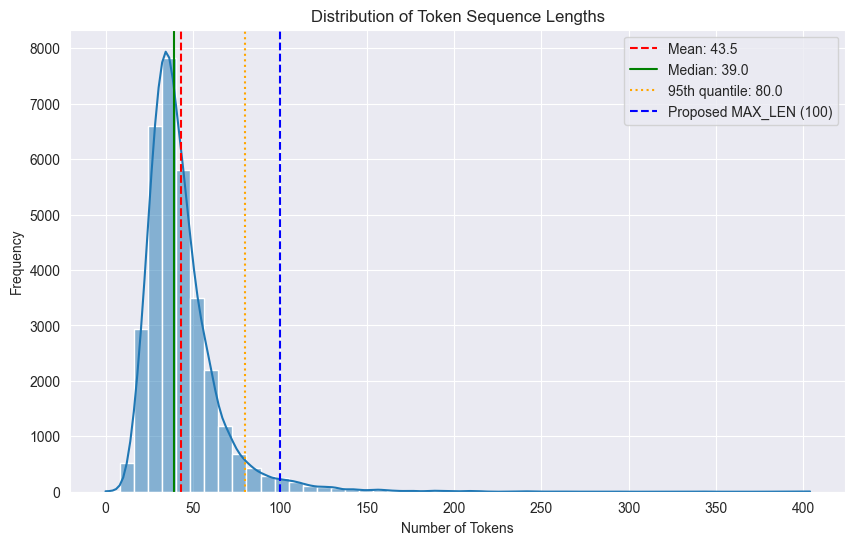

Max Token Length: 404
95th Percentile: 80.0


In [46]:
plot_token_lengths(df_train, my_tokenizer)

In [47]:
find_unique_active_tokens(df_train, my_tokenizer)

Tokens found ONLY in Active molecules: set()
Tokens found ONLY in Inactive molecules: {'[cH-]', '[Cr]', '[Cu+2]', '[IH]', '[Sb]', '[Ca-2]', '[Ru-4]', '[Au-3]', '[Fe-2]', '[Co+2]', 'p', '[Cu-3]', '[Mo]', '[MgH]', '[Hg]', '[Pt-2]', '[Pb]', '[n-]', '[Mn]', '[NH-]', '[Sn]', '[BH3-]', '[p]', '[Au-]', '[Hg-2]', '[Pd+2]', '[Co]', '[Cu-5]', '%14', '[Ni]', '>', '[K+]', '[FH+]', '[Co-2]', '[P-]', '[Ir+]', '[Bi]', '[S-2]', '[B+]', '[SH]', '[CaH2]', '[Tl-3]', '[SiH-]', '[I-]', '[Ti]', '[CH+]', '[Ru-2]', '[Tb]', '[te]', '[W]', '[AsH]', '[Ni-4]', '%11', '[H+]', '[Ga]', '[V-]', '[Fe-]', '[Gd+3]', '[Pd-4]', '[Zn-3]', '[CH3]', '[Hg-]', '[Pt+2]', '[F]', '[ClH2+]', '[Mo+2]', '%12', '[NH2]', '[Fe]', '[CH-]', '[B-]', '[As+]', '[Tl-]', '[BrH+]', '[Li]', '[Cu]', '[ClH+]', '[Ni-2]', '[Ir-4]', '[Cs+]', '[I+]', '[BH2-]', '[Mn+2]', '[Re+]', '[Ru]', '[Mn+3]', '[Br]', '[SiH]', '[b-]', '[Te]', '[S]', '[Ru+]', '[Fe+]', '[Ac]', '[Pt-4]', '[Mg]', '[Ag]', '[Ga-3]', '[H]', '[Ni-3]', '[Zn-4]', '[H-]', '[U]', '[Ge]', '[U-